In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

import seaborn as sns
import shap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier


In [137]:
# Load gene expression data 
df_expr = pd.read_csv("TCGA-BRCA.star_counts.tsv.gz", sep='\t', index_col=0)
df_expr.shape

(60660, 1226)

In [138]:
# Load clinical/phenotype data 
df_clin = pd.read_csv("TCGA.BRCA.sampleMap_BRCA_clinicalMatrix", sep='\t', index_col=0)
df_clin.shape

(1247, 193)

In [139]:
df_expr_t = df_expr.T
df_expr_t.index.name = 'sample_id'
df_expr_t = df_expr_t.reset_index()

In [140]:
#Normalize sample IDs to match clinical
df_expr_t['sample_id'] = df_expr_t['sample_id'].str[:15] 

In [141]:
#Filter clinical data for 'Primary Tumor' and 'Solid Tissue Normal'
df_clin_filtered = df_clin[df_clin['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
df_clin_filtered = df_clin_filtered.reset_index().rename(columns={'sampleID': 'sample_id'})

In [142]:
#Find shared sample IDs
shared_ids = set(df_expr_t['sample_id']).intersection(set(df_clin_filtered['sample_id']))


In [143]:
df_expr_t = df_expr_t[df_expr_t['sample_id'].isin(shared_ids)].set_index('sample_id')
df_clin_filtered = df_clin_filtered[df_clin_filtered['sample_id'].isin(shared_ids)].set_index('sample_id')

In [144]:
#Final features (X) and labels (y)
X = df_expr_t.sort_index()
y = df_clin_filtered.loc[X.index, 'sample_type'].map({'Primary Tumor': 1, 'Solid Tissue Normal': 0})

print("Final dataset shape:", X.shape)
print("Class distribution:\n", y.value_counts())

Final dataset shape: (1219, 60660)
Class distribution:
 sample_type
1    1106
0     113
Name: count, dtype: int64


In [145]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [146]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [147]:
#XGBoost
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

#Fit model with evaluation sets to track train and test loss per iteration
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
model.fit(
    X_train_scaled, y_train,
    eval_set=eval_set,
    verbose=True
)
results = model.evals_result()


C:\Users\riya\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:51:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-logloss:0.23376	validation_1-logloss:0.25074
[1]	validation_0-logloss:0.19578	validation_1-logloss:0.21903
[2]	validation_0-logloss:0.16847	validation_1-logloss:0.19310
[3]	validation_0-logloss:0.14806	validation_1-logloss:0.17417
[4]	validation_0-logloss:0.12987	validation_1-logloss:0.15767
[5]	validation_0-logloss:0.11597	validation_1-logloss:0.14324
[6]	validation_0-logloss:0.10379	validation_1-logloss:0.13063
[7]	validation_0-logloss:0.09269	validation_1-logloss:0.11962
[8]	validation_0-logloss:0.08397	validation_1-logloss:0.10983
[9]	validation_0-logloss:0.07578	validation_1-logloss:0.10086
[10]	validation_0-logloss:0.06847	validation_1-logloss:0.09260
[11]	validation_0-logloss:0.06242	validation_1-logloss:0.08683
[12]	validation_0-logloss:0.05679	validation_1-logloss:0.08163
[13]	validation_0-logloss:0.05178	validation_1-logloss:0.07717
[14]	validation_0-logloss:0.04758	validation_1-logloss:0.07309
[15]	validation_0-logloss:0.04312	validation_1-logloss:0.06863
[1

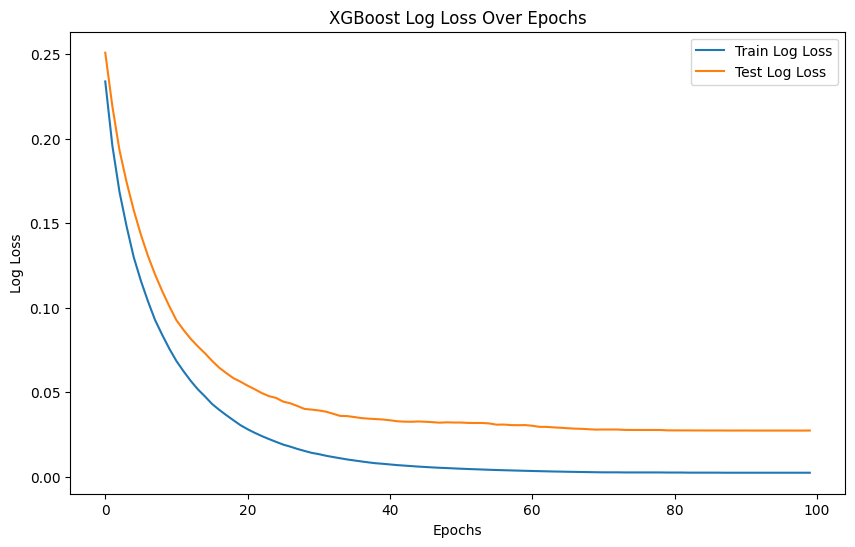

In [148]:
# Plot learning curves (log loss)
epochs = len(results['validation_0']['logloss'])
x_axis = range(epochs)

plt.figure(figsize=(10,6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test Log Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Over Epochs')
plt.legend()
plt.show()

In [149]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using cross_val_score
scores = cross_val_score(xgb_model, X_scaled, y_combined, cv=skf, scoring='accuracy')

print("Cross-validation accuracy scores:", scores)
print("Mean accuracy: {:.4f}".format(scores.mean()))
print("Standard deviation: {:.4f}".format(scores.std()))

Cross-validation accuracy scores: [0.99180328 1.         0.99590164 0.98770492 0.98765432]
Mean accuracy: 0.9926
Standard deviation: 0.0048


In [150]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.99      1.00      0.99       221

    accuracy                           0.99       244
   macro avg       0.97      0.95      0.96       244
weighted avg       0.99      0.99      0.99       244

ROC AUC Score: 0.9990163289396026


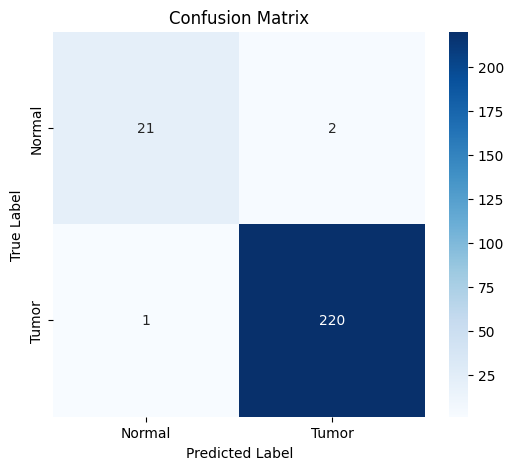

In [151]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

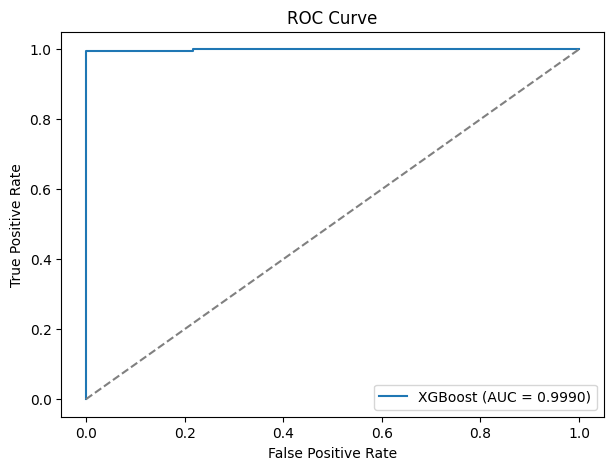

In [152]:
# 3. ROC-AUC Score + Curve
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1 (Tumor)
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

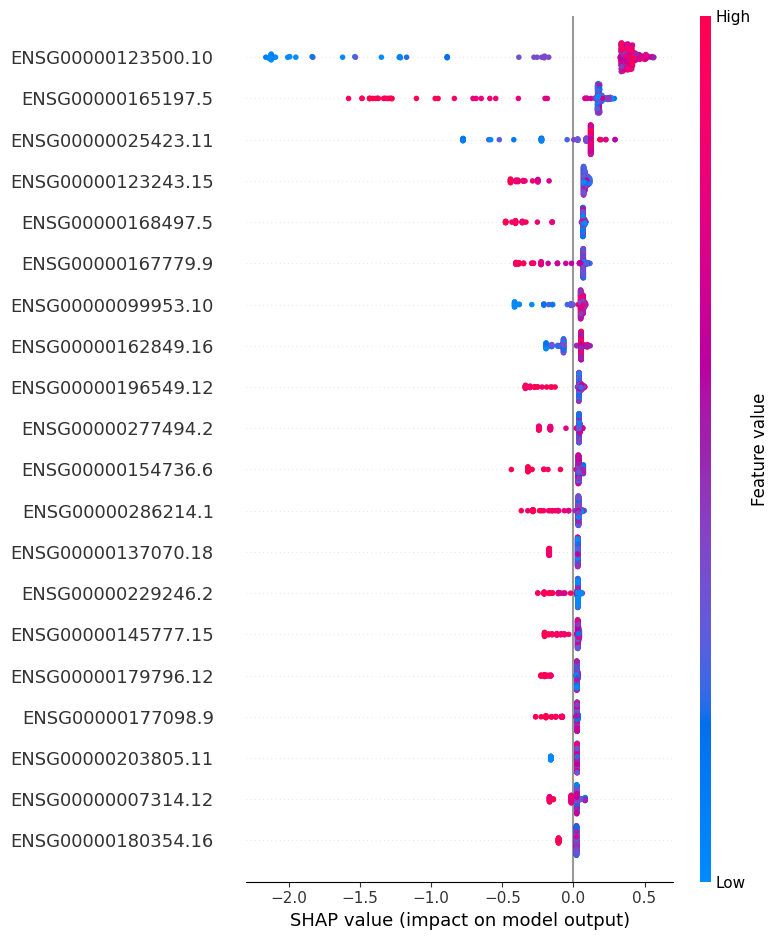

In [153]:
#explainer for XGBoost model
explainer = shap.Explainer(model, X_train_scaled, feature_names=X.columns.tolist())
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, max_display=20)

C:\Users\riya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\riya\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


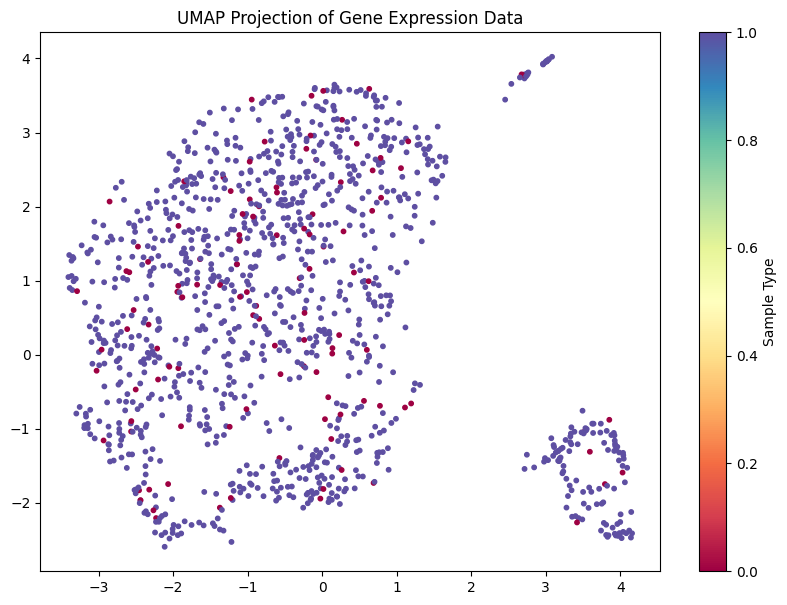

In [154]:
X_scaled = np.vstack([X_train_scaled, X_test_scaled])
y_combined = np.hstack([y_train, y_test])
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_scaled)  # X_scaled: your scaled gene expression features

plt.figure(figsize=(10,7))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Spectral', s=10)
plt.colorbar(scatter, label='Sample Type')
plt.title('UMAP Projection of Gene Expression Data')
plt.show()


In [155]:
from sklearn.ensemble import RandomForestClassifier

In [156]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [157]:
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

In [158]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      1.00      1.00       221

    accuracy                           1.00       244
   macro avg       0.98      1.00      0.99       244
weighted avg       1.00      1.00      1.00       244

ROC AUC Score: 0.999606531575841


In [159]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20

top_features = X.columns[indices[:top_n]]
top_importances = importances[indices[:top_n]]

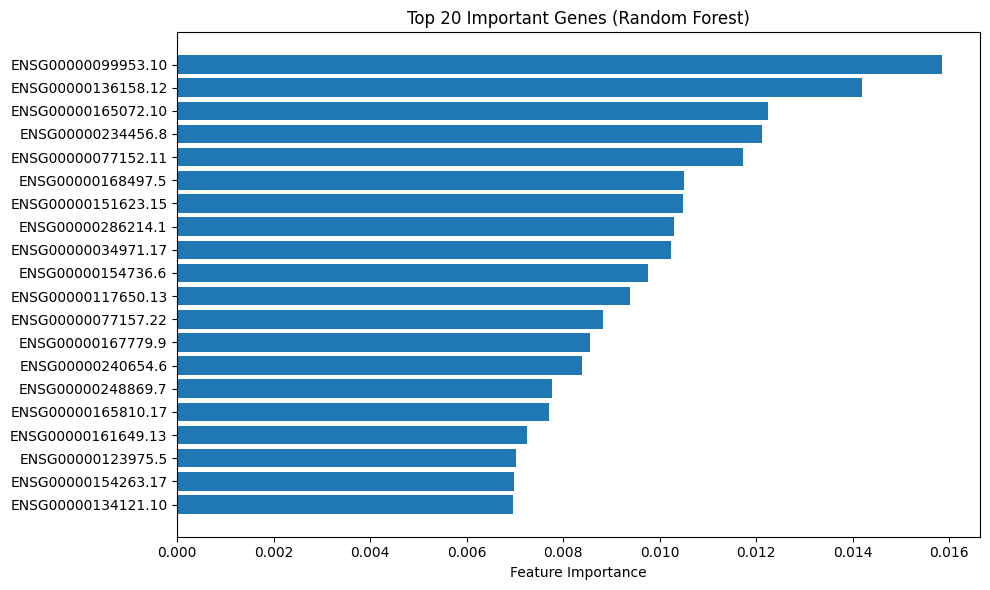

In [160]:
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances[::-1], align='center')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Genes (Random Forest)")
plt.tight_layout()
plt.show()

In [161]:
#XGBoost vs Random Forest Results

metrics = {
    'Model': ['XGBoost', 'Random Forest'],
    'Accuracy': [0.99, 1.00],
    'Precision (class 0)': [0.95, 0.96],
    'Recall (class 0)': [0.91, 1.00],
    'F1-score (class 0)': [0.93, 0.98],
    'Precision (class 1)': [0.99, 1.00],
    'Recall (class 1)': [1.00, 1.00],
    'F1-score (class 1)': [0.99, 1.00],
    'ROC AUC': [0.999, 0.9996]
}

comparison_df = pd.DataFrame(metrics)
comparison_df

,Model,Accuracy,Precision (class 0),Recall (class 0),F1-score (class 0),Precision (class 1),Recall (class 1),F1-score (class 1),ROC AUC
0,XGBoost,0.99,0.95,0.91,0.93,0.99,1.0,0.99,0.9990
1,Random Forest,1.00,0.96,1.00,0.98,1.00,1.0,1.00,0.9996
